In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
File_address = '/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/'
End = '.npy'
LES_address = File_address  + 'Anisotropy_Tensors_LES_NASA' + End
Tensors_all_address = File_address + 'Tensors_RANS' + End
Tensors_address = File_address + "Tensors" + End
Invariants_address = File_address + 'Invariants_RANS' + End
Invar_address = File_address + 'Invariants' + End
Anisotropy = np.load(LES_address)
Invariants = np.load(Invariants_address)
Invar = np.load(Invar_address)
Two_Invariants = Invariants[:,:2]
General_Tensors = np.load(Tensors_all_address)
Tensors = np.load(Tensors_address)
Five_Tensors = General_Tensors[:,:5]
Index = np.arange(Invar.shape[0])
Input_shape = Invar.shape[1]
Two_dim_anisotropy = np.zeros((140*150,4))
for i in range((140*150)):
    Two_dim_anisotropy[i][0] = Anisotropy[i][0]
    Two_dim_anisotropy[i][1] = Anisotropy[i][1]
    Two_dim_anisotropy[i][2] = Anisotropy[i][3]
    Two_dim_anisotropy[i][3] = Anisotropy[i][5]

In [3]:
X_train,X_val,Y_train,Y_val,Ind_train,Ind_val = train_test_split(Invar,Anisotropy,Index,test_size=0.2, random_state=10, shuffle=True)
Basis_train = Tensors[Ind_train]
Basis_val = Tensors[Ind_val]
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)##!Different from Example
print('Shape of Five_Tensors:',Tensors.shape)
print('Shape of Invariants:', Invar.shape)
print('Shape of LES Data:', Anisotropy.shape)
print(' ')
print('Training Invariants:')
print(X_train.shape)
print('Training tensor basis:')
print(Basis_train.shape)
print('Training labels:')
print(Y_train.shape)
print(' ')
print('Validation Invariants:')
print(X_val.shape)
print('Validation tensor basis:')
print(Basis_val.shape)
print('Validation labels:')
print(Y_val.shape)
print(' ')

Shape of Five_Tensors: (21000, 10, 3, 3)
Shape of Invariants: (21000, 5)
Shape of LES Data: (21000, 6)
 
Training Invariants:
(16800, 5)
Training tensor basis:
(16800, 10, 3, 3)
Training labels:
(16800, 6)
 
Validation Invariants:
(4200, 5)
Validation tensor basis:
(4200, 10, 3, 3)
Validation labels:
(4200, 6)
 


In [60]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()

input_layer = keras.layers.Input(shape=(Input_shape),name = 'Input_layer')
input_tensor_basis = keras.layers.Input(shape=(10,3,3),name = 'Tensor_Input_layer')

hidden1 = keras.layers.Dense(30,name='Hidden1', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation ='relu')(input_layer)
hidden2 = keras.layers.Dense(30,name='Hidden2', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "selu")(hidden1)
hidden3 = keras.layers.Dense(30,name='Hidden3', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "selu")(hidden2)
hidden4 = keras.layers.Dense(30,name='Hidden4', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "selu")(hidden3)
#hidden5 = keras.layers.Dense(30,name='Hidden5', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "selu")(hidden4)
#hidden6 = keras.layers.Dense(40,name='Hidden6', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "tanh")(hidden5)
#hidden7 = keras.layers.Dense(40,name='Hidden7', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "tanh")(hidden6)
#hidden8 = keras.layers.Dense(40,name='Hidden8', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "tanh")(hidden7)
#hidden9 = keras.layers.Dense(40,name='Hidden9', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-3), activation = "tanh")(hidden8)
gn = keras.layers.Dense(10,name='gn', kernel_initializer="lecun_normal",kernel_regularizer=tf.keras.regularizers.l2(1E-4), activation = "linear")(hidden4)


shaped = keras.layers.Reshape((10,1,1),name='Shape_for_dot_product')(gn)
merge = keras.layers.Dot(axes=1, name='Dot_product')([shaped,input_tensor_basis])

shaped_output = keras.layers.Reshape((9,1),name='Shaped_output')(merge)
trimmed_output1 = keras.layers.Lambda(lambda x : x[:,0])(shaped_output)
trimmed_output2 = keras.layers.Lambda(lambda x : x[:,1])(shaped_output)
trimmed_output3 = keras.layers.Lambda(lambda x : x[:,2])(shaped_output)
trimmed_output4 = keras.layers.Lambda(lambda x : x[:,4])(shaped_output)
trimmed_output5 = keras.layers.Lambda(lambda x : x[:,5])(shaped_output)
trimmed_output6 = keras.layers.Lambda(lambda x : x[:,8])(shaped_output)
merged_output = tf.keras.layers.Concatenate()([trimmed_output1,trimmed_output2,trimmed_output3,trimmed_output4,trimmed_output5,trimmed_output6])
#merged_output = tf.keras.layers.Concatenate()([trimmed_output1,trimmed_output2,trimmed_output4,trimmed_output6])
model=keras.Model(inputs=[input_layer,input_tensor_basis], outputs=[merged_output])

optimizer = tf.keras.optimizers.Nadam(learning_rate = 1E-5, clipnorm=1000)
model.compile(optimizer,loss='mse',metrics=['mae', 'mse'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 Hidden1 (Dense)                (None, 30)           180         ['Input_layer[0][0]']            
                                                                                                  
 Hidden2 (Dense)                (None, 30)           930         ['Hidden1[0][0]']                
                                                                                                  
 Hidden3 (Dense)                (None, 30)           930         ['Hidden2[0][0]']                
                                                                                              

In [61]:
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.2,patience=10,verbose=0,mode="auto",min_delta=0.0001,cooldown=0,min_lr=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=40,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
history = model.fit([X_train,Basis_train],Y_train,batch_size=800,epochs=1000,validation_data = ([X_val,Basis_val],Y_val),verbose=1)
#,callbacks=[early_stop,reduce_lr]

Epoch 1/1000
21/21 [==============================] - 1s 14ms/step - loss: 43.4540 - mae: 1.7590 - mse: 43.3349 - val_loss: 32.8270 - val_mae: 1.6995 - val_mse: 32.7079
Epoch 2/1000
21/21 [==============================] - 0s 5ms/step - loss: 40.0363 - mae: 1.7002 - mse: 39.9171 - val_loss: 29.8844 - val_mae: 1.6332 - val_mse: 29.7653
Epoch 3/1000
21/21 [==============================] - 0s 5ms/step - loss: 36.5512 - mae: 1.6279 - mse: 36.4320 - val_loss: 27.1991 - val_mae: 1.5645 - val_mse: 27.0800
Epoch 4/1000
21/21 [==============================] - 0s 5ms/step - loss: 33.3244 - mae: 1.5622 - mse: 33.2053 - val_loss: 24.7022 - val_mae: 1.5021 - val_mse: 24.5830
Epoch 5/1000
21/21 [==============================] - 0s 5ms/step - loss: 30.3803 - mae: 1.5007 - mse: 30.2611 - val_loss: 22.4490 - val_mae: 1.4409 - val_mse: 22.3299
Epoch 6/1000
21/21 [==============================] - 0s 4ms/step - loss: 27.7605 - mae: 1.4464 - mse: 27.6414 - val_loss: 20.3597 - val_mae: 1.3818 - val_mse:

21/21 [==============================] - 0s 5ms/step - loss: 3.1520 - mae: 0.6336 - mse: 3.0330 - val_loss: 2.4604 - val_mae: 0.6138 - val_mse: 2.3414
Epoch 51/1000
21/21 [==============================] - 0s 5ms/step - loss: 3.0613 - mae: 0.6268 - mse: 2.9422 - val_loss: 2.3973 - val_mae: 0.6074 - val_mse: 2.2783
Epoch 52/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.9715 - mae: 0.6205 - mse: 2.8525 - val_loss: 2.3388 - val_mae: 0.6012 - val_mse: 2.2198
Epoch 53/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.8878 - mae: 0.6134 - mse: 2.7688 - val_loss: 2.2801 - val_mae: 0.5948 - val_mse: 2.1611
Epoch 54/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.8077 - mae: 0.6072 - mse: 2.6887 - val_loss: 2.2256 - val_mae: 0.5890 - val_mse: 2.1066
Epoch 55/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.7257 - mae: 0.6002 - mse: 2.6067 - val_loss: 2.1760 - val_mae: 0.5829 - val_mse: 2.0570
Epoch 56/1000
21/21 [===

Epoch 100/1000
21/21 [==============================] - 0s 5ms/step - loss: 1.1582 - mae: 0.4177 - mse: 1.0393 - val_loss: 1.1386 - val_mae: 0.4163 - val_mse: 1.0197
Epoch 101/1000
21/21 [==============================] - 0s 5ms/step - loss: 1.1447 - mae: 0.4152 - mse: 1.0257 - val_loss: 1.1294 - val_mae: 0.4140 - val_mse: 1.0105
Epoch 102/1000
21/21 [==============================] - 0s 5ms/step - loss: 1.1322 - mae: 0.4130 - mse: 1.0133 - val_loss: 1.1195 - val_mae: 0.4115 - val_mse: 1.0006
Epoch 103/1000
21/21 [==============================] - 0s 5ms/step - loss: 1.1194 - mae: 0.4102 - mse: 1.0005 - val_loss: 1.1103 - val_mae: 0.4092 - val_mse: 0.9914
Epoch 104/1000
21/21 [==============================] - 0s 5ms/step - loss: 1.1072 - mae: 0.4076 - mse: 0.9882 - val_loss: 1.1021 - val_mae: 0.4071 - val_mse: 0.9831
Epoch 105/1000
21/21 [==============================] - 0s 5ms/step - loss: 1.0952 - mae: 0.4054 - mse: 0.9763 - val_loss: 1.0931 - val_mae: 0.4048 - val_mse: 0.9742
Epoc

21/21 [==============================] - 0s 5ms/step - loss: 0.7619 - mae: 0.3306 - mse: 0.6431 - val_loss: 0.8217 - val_mae: 0.3338 - val_mse: 0.7029
Epoch 150/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.7568 - mae: 0.3294 - mse: 0.6380 - val_loss: 0.8174 - val_mae: 0.3327 - val_mse: 0.6986
Epoch 151/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.7519 - mae: 0.3282 - mse: 0.6330 - val_loss: 0.8124 - val_mae: 0.3315 - val_mse: 0.6936
Epoch 152/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.7469 - mae: 0.3271 - mse: 0.6281 - val_loss: 0.8080 - val_mae: 0.3304 - val_mse: 0.6892
Epoch 153/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.7420 - mae: 0.3258 - mse: 0.6232 - val_loss: 0.8038 - val_mae: 0.3292 - val_mse: 0.6850
Epoch 154/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.7372 - mae: 0.3247 - mse: 0.6184 - val_loss: 0.7993 - val_mae: 0.3281 - val_mse: 0.6805
Epoch 155/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.5635 - mae: 0.2797 - mse: 0.4449 - val_loss: 0.6324 - val_mae: 0.2850 - val_mse: 0.5138
Epoch 199/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.5602 - mae: 0.2786 - mse: 0.4415 - val_loss: 0.6287 - val_mae: 0.2840 - val_mse: 0.5101
Epoch 200/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.5567 - mae: 0.2777 - mse: 0.4381 - val_loss: 0.6246 - val_mae: 0.2830 - val_mse: 0.5060
Epoch 201/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.5534 - mae: 0.2767 - mse: 0.4348 - val_loss: 0.6217 - val_mae: 0.2821 - val_mse: 0.5031
Epoch 202/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.5502 - mae: 0.2758 - mse: 0.4316 - val_loss: 0.6181 - val_mae: 0.2812 - val_mse: 0.4995
Epoch 203/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.5468 - mae: 0.2747 - mse: 0.4282 - val_loss: 0.6148 - val_mae: 0.2802 - val_mse: 0.4962
Epoch 204/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.4189 - mae: 0.2328 - mse: 0.3005 - val_loss: 0.4806 - val_mae: 0.2388 - val_mse: 0.3622
Epoch 248/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.4163 - mae: 0.2319 - mse: 0.2979 - val_loss: 0.4781 - val_mae: 0.2380 - val_mse: 0.3597
Epoch 249/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.4139 - mae: 0.2310 - mse: 0.2955 - val_loss: 0.4751 - val_mae: 0.2369 - val_mse: 0.3567
Epoch 250/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.4115 - mae: 0.2301 - mse: 0.2931 - val_loss: 0.4727 - val_mae: 0.2361 - val_mse: 0.3544
Epoch 251/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.4090 - mae: 0.2293 - mse: 0.2906 - val_loss: 0.4697 - val_mae: 0.2349 - val_mse: 0.3513
Epoch 252/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.4066 - mae: 0.2283 - mse: 0.2882 - val_loss: 0.4674 - val_mae: 0.2343 - val_mse: 0.3490
Epoch 253/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.3179 - mae: 0.1936 - mse: 0.1997 - val_loss: 0.3705 - val_mae: 0.1994 - val_mse: 0.2523
Epoch 297/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.3163 - mae: 0.1931 - mse: 0.1981 - val_loss: 0.3687 - val_mae: 0.1988 - val_mse: 0.2505
Epoch 298/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.3147 - mae: 0.1923 - mse: 0.1965 - val_loss: 0.3669 - val_mae: 0.1981 - val_mse: 0.2487
Epoch 299/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.3131 - mae: 0.1917 - mse: 0.1949 - val_loss: 0.3652 - val_mae: 0.1974 - val_mse: 0.2470
Epoch 300/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.3114 - mae: 0.1909 - mse: 0.1932 - val_loss: 0.3637 - val_mae: 0.1967 - val_mse: 0.2455
Epoch 301/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.3099 - mae: 0.1903 - mse: 0.1917 - val_loss: 0.3617 - val_mae: 0.1960 - val_mse: 0.2435
Epoch 302/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.2518 - mae: 0.1635 - mse: 0.1338 - val_loss: 0.2977 - val_mae: 0.1702 - val_mse: 0.1797
Epoch 346/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2507 - mae: 0.1631 - mse: 0.1327 - val_loss: 0.2961 - val_mae: 0.1693 - val_mse: 0.1781
Epoch 347/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2496 - mae: 0.1624 - mse: 0.1316 - val_loss: 0.2954 - val_mae: 0.1689 - val_mse: 0.1774
Epoch 348/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2485 - mae: 0.1619 - mse: 0.1305 - val_loss: 0.2938 - val_mae: 0.1683 - val_mse: 0.1758
Epoch 349/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2474 - mae: 0.1614 - mse: 0.1295 - val_loss: 0.2927 - val_mae: 0.1678 - val_mse: 0.1747
Epoch 350/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2464 - mae: 0.1609 - mse: 0.1285 - val_loss: 0.2914 - val_mae: 0.1674 - val_mse: 0.1735
Epoch 351/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.2091 - mae: 0.1392 - mse: 0.0913 - val_loss: 0.2479 - val_mae: 0.1459 - val_mse: 0.1301
Epoch 395/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2085 - mae: 0.1387 - mse: 0.0907 - val_loss: 0.2467 - val_mae: 0.1453 - val_mse: 0.1289
Epoch 396/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2078 - mae: 0.1383 - mse: 0.0900 - val_loss: 0.2461 - val_mae: 0.1451 - val_mse: 0.1283
Epoch 397/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2071 - mae: 0.1378 - mse: 0.0894 - val_loss: 0.2454 - val_mae: 0.1446 - val_mse: 0.1276
Epoch 398/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2065 - mae: 0.1374 - mse: 0.0888 - val_loss: 0.2445 - val_mae: 0.1440 - val_mse: 0.1268
Epoch 399/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.2058 - mae: 0.1370 - mse: 0.0881 - val_loss: 0.2435 - val_mae: 0.1436 - val_mse: 0.1258
Epoch 400/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1832 - mae: 0.1201 - mse: 0.0656 - val_loss: 0.2161 - val_mae: 0.1269 - val_mse: 0.0985
Epoch 444/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1828 - mae: 0.1199 - mse: 0.0653 - val_loss: 0.2156 - val_mae: 0.1268 - val_mse: 0.0981
Epoch 445/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.1824 - mae: 0.1195 - mse: 0.0649 - val_loss: 0.2154 - val_mae: 0.1265 - val_mse: 0.0978
Epoch 446/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1820 - mae: 0.1192 - mse: 0.0645 - val_loss: 0.2144 - val_mae: 0.1261 - val_mse: 0.0969
Epoch 447/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1816 - mae: 0.1189 - mse: 0.0640 - val_loss: 0.2139 - val_mae: 0.1256 - val_mse: 0.0964
Epoch 448/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1813 - mae: 0.1186 - mse: 0.0637 - val_loss: 0.2133 - val_mae: 0.1256 - val_mse: 0.0957
Epoch 449/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1666 - mae: 0.1063 - mse: 0.0493 - val_loss: 0.1928 - val_mae: 0.1128 - val_mse: 0.0755
Epoch 493/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1664 - mae: 0.1061 - mse: 0.0491 - val_loss: 0.1921 - val_mae: 0.1127 - val_mse: 0.0748
Epoch 494/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1661 - mae: 0.1059 - mse: 0.0488 - val_loss: 0.1921 - val_mae: 0.1126 - val_mse: 0.0748
Epoch 495/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1659 - mae: 0.1056 - mse: 0.0486 - val_loss: 0.1916 - val_mae: 0.1128 - val_mse: 0.0744
Epoch 496/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1655 - mae: 0.1053 - mse: 0.0482 - val_loss: 0.1913 - val_mae: 0.1120 - val_mse: 0.0741
Epoch 497/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1653 - mae: 0.1051 - mse: 0.0480 - val_loss: 0.1910 - val_mae: 0.1120 - val_mse: 0.0738
Epoch 498/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1552 - mae: 0.0960 - mse: 0.0383 - val_loss: 0.1780 - val_mae: 0.1028 - val_mse: 0.0611
Epoch 542/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1551 - mae: 0.0958 - mse: 0.0381 - val_loss: 0.1775 - val_mae: 0.1024 - val_mse: 0.0606
Epoch 543/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1549 - mae: 0.0957 - mse: 0.0379 - val_loss: 0.1769 - val_mae: 0.1017 - val_mse: 0.0599
Epoch 544/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1547 - mae: 0.0954 - mse: 0.0377 - val_loss: 0.1771 - val_mae: 0.1019 - val_mse: 0.0602
Epoch 545/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1545 - mae: 0.0953 - mse: 0.0376 - val_loss: 0.1769 - val_mae: 0.1018 - val_mse: 0.0599
Epoch 546/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1543 - mae: 0.0951 - mse: 0.0374 - val_loss: 0.1764 - val_mae: 0.1013 - val_mse: 0.0594
Epoch 547/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1472 - mae: 0.0878 - mse: 0.0306 - val_loss: 0.1677 - val_mae: 0.0941 - val_mse: 0.0511
Epoch 591/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1471 - mae: 0.0876 - mse: 0.0305 - val_loss: 0.1674 - val_mae: 0.0941 - val_mse: 0.0508
Epoch 592/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1469 - mae: 0.0875 - mse: 0.0303 - val_loss: 0.1671 - val_mae: 0.0937 - val_mse: 0.0505
Epoch 593/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1468 - mae: 0.0874 - mse: 0.0302 - val_loss: 0.1673 - val_mae: 0.0944 - val_mse: 0.0507
Epoch 594/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1467 - mae: 0.0871 - mse: 0.0301 - val_loss: 0.1665 - val_mae: 0.0932 - val_mse: 0.0499
Epoch 595/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1465 - mae: 0.0870 - mse: 0.0300 - val_loss: 0.1665 - val_mae: 0.0932 - val_mse: 0.0499
Epoch 596/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1413 - mae: 0.0808 - mse: 0.0251 - val_loss: 0.1584 - val_mae: 0.0870 - val_mse: 0.0422
Epoch 640/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1413 - mae: 0.0807 - mse: 0.0251 - val_loss: 0.1586 - val_mae: 0.0871 - val_mse: 0.0424
Epoch 641/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1411 - mae: 0.0806 - mse: 0.0250 - val_loss: 0.1581 - val_mae: 0.0866 - val_mse: 0.0420
Epoch 642/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1410 - mae: 0.0804 - mse: 0.0249 - val_loss: 0.1581 - val_mae: 0.0867 - val_mse: 0.0419
Epoch 643/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1409 - mae: 0.0803 - mse: 0.0248 - val_loss: 0.1578 - val_mae: 0.0865 - val_mse: 0.0417
Epoch 644/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1409 - mae: 0.0803 - mse: 0.0247 - val_loss: 0.1578 - val_mae: 0.0863 - val_mse: 0.0417
Epoch 645/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1370 - mae: 0.0751 - mse: 0.0212 - val_loss: 0.1515 - val_mae: 0.0808 - val_mse: 0.0357
Epoch 689/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1369 - mae: 0.0750 - mse: 0.0211 - val_loss: 0.1517 - val_mae: 0.0811 - val_mse: 0.0360
Epoch 690/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1368 - mae: 0.0749 - mse: 0.0210 - val_loss: 0.1512 - val_mae: 0.0808 - val_mse: 0.0355
Epoch 691/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1367 - mae: 0.0748 - mse: 0.0210 - val_loss: 0.1512 - val_mae: 0.0807 - val_mse: 0.0354
Epoch 692/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1366 - mae: 0.0747 - mse: 0.0209 - val_loss: 0.1512 - val_mae: 0.0808 - val_mse: 0.0354
Epoch 693/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1366 - mae: 0.0745 - mse: 0.0208 - val_loss: 0.1507 - val_mae: 0.0802 - val_mse: 0.0350
Epoch 694/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1335 - mae: 0.0704 - mse: 0.0182 - val_loss: 0.1460 - val_mae: 0.0759 - val_mse: 0.0307
Epoch 738/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1335 - mae: 0.0704 - mse: 0.0182 - val_loss: 0.1461 - val_mae: 0.0761 - val_mse: 0.0308
Epoch 739/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1334 - mae: 0.0702 - mse: 0.0182 - val_loss: 0.1458 - val_mae: 0.0758 - val_mse: 0.0306
Epoch 740/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1334 - mae: 0.0701 - mse: 0.0181 - val_loss: 0.1459 - val_mae: 0.0757 - val_mse: 0.0306
Epoch 741/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1333 - mae: 0.0700 - mse: 0.0181 - val_loss: 0.1456 - val_mae: 0.0757 - val_mse: 0.0304
Epoch 742/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1332 - mae: 0.0699 - mse: 0.0180 - val_loss: 0.1455 - val_mae: 0.0753 - val_mse: 0.0302
Epoch 743/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1307 - mae: 0.0663 - mse: 0.0160 - val_loss: 0.1423 - val_mae: 0.0727 - val_mse: 0.0276
Epoch 787/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1307 - mae: 0.0663 - mse: 0.0159 - val_loss: 0.1421 - val_mae: 0.0723 - val_mse: 0.0273
Epoch 788/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1306 - mae: 0.0662 - mse: 0.0159 - val_loss: 0.1416 - val_mae: 0.0719 - val_mse: 0.0269
Epoch 789/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1306 - mae: 0.0662 - mse: 0.0159 - val_loss: 0.1417 - val_mae: 0.0717 - val_mse: 0.0269
Epoch 790/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1305 - mae: 0.0660 - mse: 0.0158 - val_loss: 0.1415 - val_mae: 0.0716 - val_mse: 0.0268
Epoch 791/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1305 - mae: 0.0660 - mse: 0.0158 - val_loss: 0.1417 - val_mae: 0.0721 - val_mse: 0.0270
Epoch 792/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1284 - mae: 0.0631 - mse: 0.0142 - val_loss: 0.1383 - val_mae: 0.0684 - val_mse: 0.0241
Epoch 836/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1283 - mae: 0.0630 - mse: 0.0141 - val_loss: 0.1384 - val_mae: 0.0686 - val_mse: 0.0242
Epoch 837/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1283 - mae: 0.0630 - mse: 0.0141 - val_loss: 0.1386 - val_mae: 0.0695 - val_mse: 0.0244
Epoch 838/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1283 - mae: 0.0629 - mse: 0.0141 - val_loss: 0.1384 - val_mae: 0.0688 - val_mse: 0.0242
Epoch 839/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1282 - mae: 0.0628 - mse: 0.0140 - val_loss: 0.1381 - val_mae: 0.0683 - val_mse: 0.0240
Epoch 840/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1282 - mae: 0.0628 - mse: 0.0140 - val_loss: 0.1381 - val_mae: 0.0688 - val_mse: 0.0240
Epoch 841/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1264 - mae: 0.0603 - mse: 0.0127 - val_loss: 0.1359 - val_mae: 0.0664 - val_mse: 0.0223
Epoch 885/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1263 - mae: 0.0602 - mse: 0.0127 - val_loss: 0.1355 - val_mae: 0.0659 - val_mse: 0.0219
Epoch 886/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1263 - mae: 0.0602 - mse: 0.0127 - val_loss: 0.1353 - val_mae: 0.0657 - val_mse: 0.0217
Epoch 887/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1263 - mae: 0.0602 - mse: 0.0127 - val_loss: 0.1354 - val_mae: 0.0657 - val_mse: 0.0218
Epoch 888/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1262 - mae: 0.0601 - mse: 0.0126 - val_loss: 0.1353 - val_mae: 0.0653 - val_mse: 0.0217
Epoch 889/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1262 - mae: 0.0600 - mse: 0.0126 - val_loss: 0.1356 - val_mae: 0.0662 - val_mse: 0.0220
Epoch 890/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1246 - mae: 0.0579 - mse: 0.0116 - val_loss: 0.1330 - val_mae: 0.0634 - val_mse: 0.0200
Epoch 934/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1246 - mae: 0.0579 - mse: 0.0116 - val_loss: 0.1331 - val_mae: 0.0638 - val_mse: 0.0201
Epoch 935/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1245 - mae: 0.0578 - mse: 0.0115 - val_loss: 0.1333 - val_mae: 0.0639 - val_mse: 0.0202
Epoch 936/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1245 - mae: 0.0577 - mse: 0.0115 - val_loss: 0.1329 - val_mae: 0.0631 - val_mse: 0.0199
Epoch 937/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1244 - mae: 0.0577 - mse: 0.0115 - val_loss: 0.1329 - val_mae: 0.0631 - val_mse: 0.0199
Epoch 938/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1244 - mae: 0.0577 - mse: 0.0114 - val_loss: 0.1329 - val_mae: 0.0636 - val_mse: 0.0199
Epoch 939/1000
21/2

21/21 [==============================] - 0s 5ms/step - loss: 0.1230 - mae: 0.0559 - mse: 0.0106 - val_loss: 0.1309 - val_mae: 0.0614 - val_mse: 0.0185
Epoch 983/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1230 - mae: 0.0558 - mse: 0.0106 - val_loss: 0.1310 - val_mae: 0.0615 - val_mse: 0.0186
Epoch 984/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1229 - mae: 0.0558 - mse: 0.0106 - val_loss: 0.1308 - val_mae: 0.0613 - val_mse: 0.0184
Epoch 985/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1229 - mae: 0.0558 - mse: 0.0105 - val_loss: 0.1310 - val_mae: 0.0616 - val_mse: 0.0187
Epoch 986/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1229 - mae: 0.0557 - mse: 0.0105 - val_loss: 0.1308 - val_mae: 0.0613 - val_mse: 0.0185
Epoch 987/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.1229 - mae: 0.0557 - mse: 0.0105 - val_loss: 0.1308 - val_mae: 0.0613 - val_mse: 0.0184
Epoch 988/1000
21/2

In [62]:
model.evaluate([X_val,Basis_val],Y_val)

132/132 [==============================] - 0s 2ms/step - loss: 0.1302 - mae: 0.0610 - mse: 0.0180


[0.13019071519374847, 0.0609515942633152, 0.018018223345279694]

In [63]:
model.layers[5].weights[1].numpy()
w = model.layers[5].weights[1].numpy()
p_b = np.zeros((140*150,3,3))
for i in range(140*150):
    for j in range(10):
        p_b[i] += w[j] * Tensors[i][j] 
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/p_b_TBNN.npy",p_b)

In [64]:
model.layers[5].weights[1].numpy()

array([ 0.02891372, -0.01477414,  0.00939777, -0.00986703, -0.04950547,
        0.00457328, -0.00867491, -0.00129103, -0.00852008, -0.00186418],
      dtype=float32)

In [ ]:
save = model.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN")

In [59]:
p_b = model.predict([Invar,Tensors])
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/p_b_TBNN.npy",p_b)

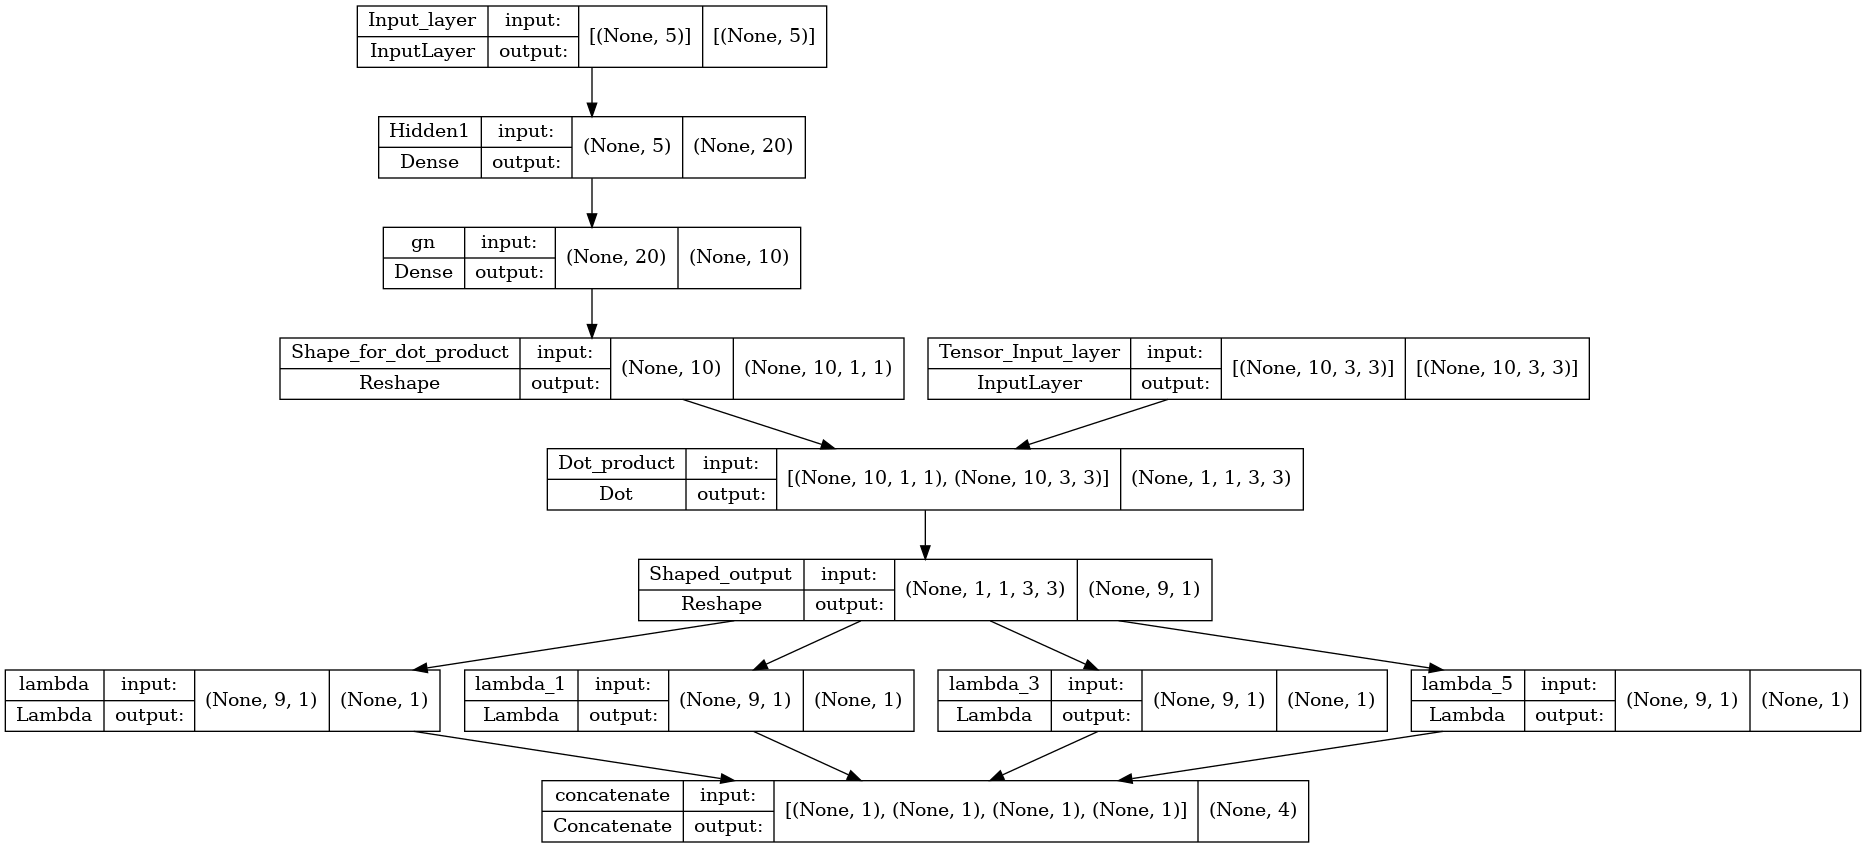

In [5]:
keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)